## ViT CiFar-100 Example
Based on: https://keras.io/examples/vision/image_classification_with_vision_transformer/

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow

from tensorflow.keras import layers
from tensorflow.keras import ops

x_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 1)


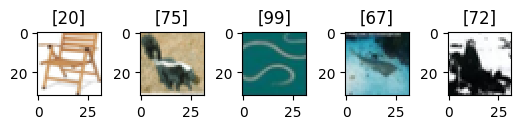

In [4]:
num_classes = 100
input_shape = (32, 32, 3)

(x_train, y_train), (x_test, y_test) = tensorflow.keras.datasets.cifar100.load_data()

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

for j in range(5):
    i = np.random.randint(0, 10000)
    plt.subplot(550 + 1 + j)
    plt.imshow(x_train[i], cmap='gray')
    plt.title(y_train[i])
plt.show()

In [5]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 10  # For real training, use num_epochs=100. 10 is a test value
image_size = 72  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [
    2048,
    1024,
]  # Size of the dense layers of the final classifier

In [7]:
data_augmentation = tensorflow.keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

In [18]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tensorflow.keras.activations.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [11]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        input_shape = ops.shape(images)
        batch_size = input_shape[0]
        height = input_shape[1]
        width = input_shape[2]
        channels = input_shape[3]

        num_patches_h = height // self.patch_size
        num_patches_w = width // self.patch_size
        
        patches = tensorflow.keras.ops.image.extract_patches(images, size=self.patch_size)
        patches = ops.reshape(
            patches,
            (
                batch_size,
                num_patches_h * num_patches_w,
                self.patch_size * self.patch_size * channels,
            ),
        )
        return patches

    def get_config(self):
        config = super().get_config()
        config.update({"patch_size": self.patch_size})
        return config

In [14]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = ops.expand_dims(
            ops.arange(start=0, stop=self.num_patches, step=1), axis=0
        )
        projected_patches = self.projection(patch)
        encoded = projected_patches + self.position_embedding(positions)
        return encoded

    def get_config(self):
        config = super().get_config()
        config.update({"num_patches": self.num_patches})
        return config

Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 108


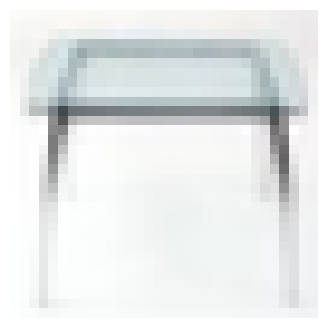

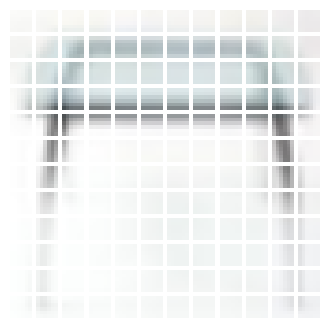

In [12]:
plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = ops.image.resize(
    ops.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = ops.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(ops.convert_to_numpy(patch_img).astype("uint8"))
    plt.axis("off")

In [20]:
input_data = layers.Input(shape=input_shape)

augmented = data_augmentation(input_data)
patches = Patches(patch_size)(augmented)
encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

optimizer = tensorflow.keras.optimizers.AdamW(learning_rate=learning_rate, weight_decay=weight_decay)

for _ in range(transformer_layers):
    n1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)

    attention_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim, dropout=0.1)(n1, n1)
    
    n2 = layers.Add()([attention_output, encoded_patches])
    
    n3 = layers.LayerNormalization(epsilon=1e-6)(n2)
    
    n3 = mlp(n3, hidden_units=transformer_units, dropout_rate=0.1)
    
    encoded_patches = layers.Add()([n3, n2])

representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
representation = layers.Flatten()(representation)
representation = layers.Dropout(0.5)(representation)

features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)

logits = layers.Dense(num_classes)(features)

model = tensorflow.keras.Model(inputs=input_data, outputs=logits)

model.compile(
    optimizer=optimizer,
    loss=tensorflow.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[
        tensorflow.keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
        tensorflow.keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
    ],
)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ data_augmentation   │ (None, 72, 72, 3) │          7 │ input_layer_5[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ patches_6 (Patches) │ (None, 144, 108)  │          0 │ data_augmentatio… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ patch_encoder_4     │ (None, 144, 64)   │     16,192 │ patches_6[0][0]   │
│ (PatchEncoder)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 144, 64)   │        128 │ patch_encoder_4[… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 144, 64)   │     66,368 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_17 (Add)        │ (None, 144, 64)   │          0 │ multi_head_atten… │
│                     │                   │            │ patch_encoder_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 144, 64)   │        128 │ add_17[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_24 (Dense)    │ (None, 144, 128)  │      8,320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_29          │ (None, 144, 128)  │          0 │ dense_24[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_25 (Dense)    │ (None, 144, 64)   │      8,256 │ dropout_29[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_30          │ (None, 144, 64)   │          0 │ dense_25[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_18 (Add)        │ (None, 144, 64)   │          0 │ dropout_30[0][0], │
│                     │                   │            │ add_17[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 144, 64)   │        128 │ add_18[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 144, 64)   │     66,368 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_19 (Add)        │ (None, 144, 64)   │          0 │ multi_head_atten… │
│                     │                   │            │ add_18[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 144, 64)   │        128 │ add_19[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_26 (Dense)    │ (None, 144, 128)  │      8,320 │ layer_normalizat

 Total params: 21,759,019 (83.00 MB)

 Trainable params: 21,759,012 (83.00 MB)

 Non-trainable params: 7 (32.00 B)

In [21]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=batch_size,
    epochs=num_epochs,
    validation_split=0.1,
)

Epoch 1/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 693s 4s/step - accuracy: 0.0285 - loss: 4.8959 - top-5-accuracy: 0.1109 - val_accuracy: 0.1012 - val_loss: 3.9358 - val_top-5-accuracy: 0.2954
Epoch 2/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 1764s 10s/step - accuracy: 0.0833 - loss: 4.0518 - top-5-accuracy: 0.2624 - val_accuracy: 0.1544 - val_loss: 3.6000 - val_top-5-accuracy: 0.3972
Epoch 3/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 718s 4s/step - accuracy: 0.1208 - loss: 3.7631 - top-5-accuracy: 0.3449 - val_accuracy: 0.1930 - val_loss: 3.3891 - val_top-5-accuracy: 0.4638
Epoch 4/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 712s 4s/step - accuracy: 0.1515 - loss: 3.5687 - top-5-accuracy: 0.4051 - val_accuracy: 0.2126 - val_loss: 3.2415 - val_top-5-accuracy: 0.4962
Epoch 5/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 720s 4s/step - accuracy: 0.1684 - loss: 3.4672 - top-5-accuracy: 0.4331 - val_accuracy: 0.2390 - val_loss: 3.1154 - val_top-5-accuracy: 0.5192
Epoch 6/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 720s 4s/step - accuracy: 0.1953 - loss: 3.3

In [22]:
_, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
print(f"Test accuracy: {round(accuracy * 100, 2)}%")
print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

313/313 ━━━━━━━━━━━━━━━━━━━━ 81s 260ms/step - accuracy: 0.2679 - loss: 2.9828 - top-5-accuracy: 0.5637
Test accuracy: 26.95%
Test top 5 accuracy: 55.88%
